In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import datetime
import torch

# Data Munging

In [3]:
from src.data_utils import convert_to_h5, train_test_split_face

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
data_dir = './data'

In [5]:
# convert_to_h5(data_dir)
# train_test_split_face(data_dir, face_id=1)

# Convolutional Features

In [6]:
import torch.nn as nn
from torch import optim

In [7]:
from src.modules import ResNetSimple
from src.data_utils import VideoDataset
from src.spatial_transforms import (Compose, Normalize, Scale, ToTensor)
from src.temporal_transforms import LoopPadding

sample_duration=10
mean, std = [0.43216, 0.394666, 0.37645], [0.22803, 0.22145, 0.216989]

spatial_transform = Compose([Scale(200), ToTensor(), Normalize(mean, std)])
temporal_transform = LoopPadding(sample_duration)

In [11]:
print_every = 1
epochs = 5

mod = ResNetSimple(device=device)
mod.to(device)
model = nn.DataParallel(mod)
pass;

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
criterion = nn.CrossEntropyLoss()

trainset = VideoDataset(device=device,
    h5_path=data_dir+'/train_1.h5', 
    sample_duration=sample_duration,
    spatial_transform=spatial_transform, 
    temporal_transform=temporal_transform,
)

testset = VideoDataset(device=device,
    h5_path=data_dir+'/test_1.h5', 
    sample_duration=sample_duration,
    spatial_transform=spatial_transform, 
    temporal_transform=temporal_transform
)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=30, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=30, shuffle=False)
pass;

In [13]:
from collections import Counter

Counter([x['label'].detach().item() for x in trainset])
Counter([x['label'].detach().item() for x in testset])

Counter({1: 520, 0: 10})

Counter({1: 265, 0: 10})

In [14]:
time_start = datetime.datetime.now()
print('Start Time: %s'%time_start.strftime('%H:%M:%S'))

for epoch in range(0, epochs):
    epoch_start = datetime.datetime.now()
    model.train();
    train_loss = 0.0
    test_loss = 0.0
    train_nbatches = 0
    test_nbatches = 0
    
    step = 0
    for inputs in trainloader:
        preds = model(**inputs)

        loss = criterion(preds, inputs['label'].squeeze())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if step%5==0:
            print('Step: {} || Train Loss: {:.3f}'.format(str(step).zfill(4), loss.item()))
        step+=1
        
        train_loss += float(loss)
        train_nbatches += 1
    
    model.eval();
    with torch.no_grad():
        for inputs in testloader:
            preds = model(**inputs)
            loss = criterion(preds, inputs['label'].squeeze())
            test_loss += float(loss)
            test_nbatches += 1

    train_loss/=train_nbatches
    test_loss/=test_nbatches
    
    if epoch%print_every == 0:
        print('Epoch {} || Train Loss: {:.3f} || Test Loss: {:.3f}'.format(
            str(epoch).zfill(3), train_loss, test_loss)
             )
time_finish = datetime.datetime.now()
print('End Time: %s'%time_finish.strftime('%H:%M:%S'))
print('Completed in %s seconds'%(time_finish-time_start).total_seconds())
torch.save(model.state_dict(), 'checkpoints/res_nonlinear_1.pt')
pass;

Start Time: 08:59:03
Step: 0000 || Train Loss: 0.604
Step: 0005 || Train Loss: 0.487
Step: 0010 || Train Loss: 0.358
Step: 0015 || Train Loss: 0.308
Epoch 000 || Train Loss: 0.405 || Test Loss: 0.361
Step: 0000 || Train Loss: 0.364
Step: 0005 || Train Loss: 0.222
Step: 0010 || Train Loss: 0.144
Step: 0015 || Train Loss: 0.107
Epoch 001 || Train Loss: 0.178 || Test Loss: 0.334
Step: 0000 || Train Loss: 0.159
Step: 0005 || Train Loss: 0.174
Step: 0010 || Train Loss: 0.061
Step: 0015 || Train Loss: 0.046
Epoch 002 || Train Loss: 0.112 || Test Loss: 0.347
Step: 0000 || Train Loss: 0.050
Step: 0005 || Train Loss: 0.118
Step: 0010 || Train Loss: 0.111
Step: 0015 || Train Loss: 0.036
Epoch 003 || Train Loss: 0.094 || Test Loss: 0.346
Step: 0000 || Train Loss: 0.034
Step: 0005 || Train Loss: 0.113
Step: 0010 || Train Loss: 0.027
Step: 0015 || Train Loss: 0.194
Epoch 004 || Train Loss: 0.085 || Test Loss: 0.344
End Time: 09:04:02
Completed in 299.808974 seconds


# Evaluate Model

In [15]:
import matplotlib.pyplot as plt
from src.metrics import make_ROC, make_PR

In [16]:
# model = ResNetSimple(device=device)
# model.to(device)
# model.load_state_dict(torch.load('checkpoints/res_nonlinear_1.pt'))
# pass;

In [37]:
devset = VideoDataset(device=device,
    h5_path=data_dir+'/test_1.h5', 
    sample_duration=sample_duration,
    spatial_transform=spatial_transform, 
    temporal_transform=temporal_transform
)

devloader = torch.utils.data.DataLoader(devset, batch_size=20, shuffle=True)

In [38]:
all_preds = []
all_labels = []

for dev in devloader:
    all_preds.append(model(**dev).cpu())
    all_labels.append(dev['label'].cpu())

ROC AUC=0.825


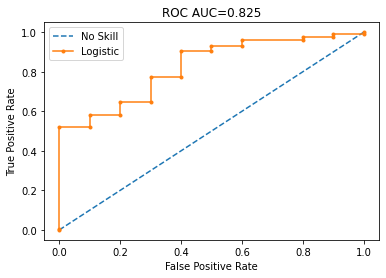

In [39]:
make_ROC(torch.cat(all_preds, dim=0), torch.cat(all_labels, dim=0))

PR AUC=0.992


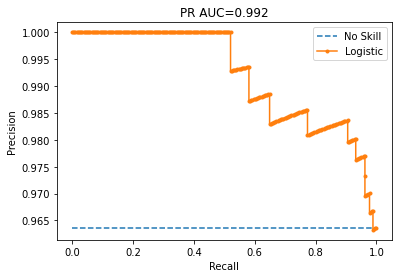

In [40]:
make_PR(torch.cat(all_preds, dim=0), torch.cat(all_labels, dim=0))

In [ ]:
blah

# Optical Flow Features

In [ ]:
with h5py.File(os.path.join('static_dataset', 'data.h5'), 'r') as f:
    testvid = f['00000'][:]

In [ ]:
def compute_optical_flow(frames):
    flow_array = np.empty(frames.shape).astype(np.uint8)
    first_frame = frames[0]
    prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY) 
    
    mask = np.zeros_like(first_frame) 
    # Sets image saturation to maximum 
    mask[..., 1] = 255
    
    n = 0
    
    for frame in frames:

        # Converts each frame to grayscale - we previously  
        # only converted the first frame to grayscale 
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 

        # Calculates dense optical flow by Farneback method 
        flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0) 

        # Computes the magnitude and angle of the 2D vectors 
        magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1]) 

        # Sets image hue according to the optical flow  
        # direction 
        mask[..., 0] = angle * 180 / np.pi / 2

        # Sets image value according to the optical flow 
        # magnitude (normalized) 
        mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX) 

        # Converts HSV to RGB (BGR) color representation 
        rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR) 
        flow_array[n] = rgb
        n+=1
        # Opens a new window and displays the output frame 

        # Updates previous frame 
        prev_gray = gray 
    return flow_array

import numpy as np
import scipy.stats as stats

def compute_power(image):
    image = np.sum(image, axis=-1)
    h, w = image.shape
    
    fourier_image = np.fft.fftn(image)
    fourier_amplitudes = np.abs(fourier_image)**2
    
    kfreq = np.fft.fftfreq(h) * w
    kfreq2D = np.meshgrid(kfreq, kfreq)
    
    knrm = np.sqrt(kfreq2D[0]**2 + kfreq2D[1]**2).flatten()
    fourier_amplitudes = fourier_amplitudes.flatten()

    kbins = np.arange(0.5, int(h/2)+1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    
    Abins, _, _ = stats.binned_statistic(knrm, fourier_amplitudes, statistic = "mean", bins = kbins)
    Abins *= 4. * np.pi / 3. * (kbins[1:]**3 - kbins[:-1]**3)
    return kvals, Abins

In [ ]:
flows = compute_optical_flow(testvid)

In [ ]:
import pylab as pl

pl.loglog(*compute_power(flows[15]))
pl.xlabel("$k$")
pl.ylabel("$P(k)$")
pl.tight_layout()
# pl.savefig("cloud_power_spectrum.png", dpi = 300, bbox_inches = "tight")

In [ ]:
from PIL import Image

In [ ]:
Image.fromarray(flows[15])

In [ ]:
Image.fromarray(testvid[15])